In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16


In [3]:
TRAINING_PATH = 'asl_alphabet_train/'
TEST_PATH = 'asl_alphabet_test/'

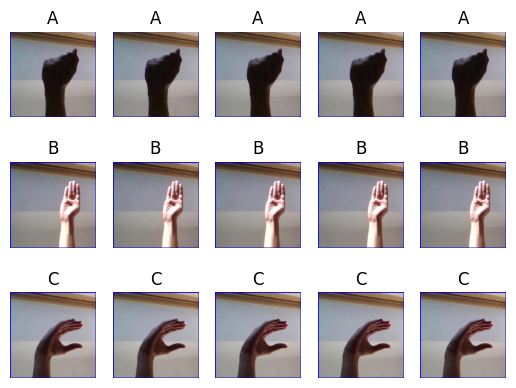

In [4]:
num_rows = 3
num_columns = 5

letters = sorted(os.listdir(TRAINING_PATH))
for row in range(num_rows):
    letter = letters[row]
    for col in range(num_columns):
        index = row * num_columns + col + 1
        subplot = plt.subplot(num_rows, num_columns, index)
        subplot.axis('Off')
        subplot.set_title(letter)
        try:
            image_files = os.listdir(os.path.join(TRAINING_PATH, letter))
            if image_files:  # Check if there are any image files for the letter
                image_path = os.path.join(TRAINING_PATH, letter, image_files[0])  # Select the first image
                image = mpimg.imread(image_path)
                plt.imshow(image)
            else:
                raise FileNotFoundError("No image found for category.")
        except FileNotFoundError:
            print(f"Image not found for category {letter}")

plt.show()


In [4]:
IMAGE_SIZE = 200
BATCH_SIZE = 64

In [5]:
data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(TRAINING_PATH, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(TRAINING_PATH, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")
     

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [115]:
# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(29, activation='softmax')) 

# Print the model summary
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_303 (Conv2D)         (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_304 (Conv2D)         (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_305 (Conv2D)         (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 23, 23, 128)     

In [117]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    min_delta=0.001,         # Consider an improvement that increases accuracy by 0.001
    patience=10,             # Wait for 10 epochs after the last improvement
    verbose=1,               # Print out messages when stopping
    mode='max',              # Maximize validation accuracy
    restore_best_weights=True # Restore model weights from the epoch with the highest validation accuracy
)

In [118]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [119]:
hist = model.fit(train_generator,
                 validation_data=validation_generator,
                 steps_per_epoch=100,
                 epochs=50, 
                 batch_size=BATCH_SIZE,
                 callbacks=[early_stopping] 
                 )

Epoch 1/50
100/100 [==============================] - 132s 1s/step - loss: 2.7782 - accuracy: 0.2230 - val_loss: 2.3230 - val_accuracy: 0.2864
Epoch 2/50
100/100 [==============================] - 144s 1s/step - loss: 1.2419 - accuracy: 0.6225 - val_loss: 1.8183 - val_accuracy: 0.4483
Epoch 3/50
100/100 [==============================] - 145s 1s/step - loss: 0.6658 - accuracy: 0.7861 - val_loss: 1.6923 - val_accuracy: 0.5375
Epoch 4/50
100/100 [==============================] - 149s 1s/step - loss: 0.4431 - accuracy: 0.8569 - val_loss: 1.6908 - val_accuracy: 0.5715
Epoch 5/50
100/100 [==============================] - 150s 2s/step - loss: 0.3299 - accuracy: 0.8948 - val_loss: 1.7837 - val_accuracy: 0.5949
Epoch 6/50
100/100 [==============================] - 141s 1s/step - loss: 0.2495 - accuracy: 0.9200 - val_loss: 1.7607 - val_accuracy: 0.6402
Epoch 7/50
100/100 [==============================] - 142s 1s/step - loss: 0.1816 - accuracy: 0.9389 - val_loss: 1.4556 - val_accuracy: 0.6559

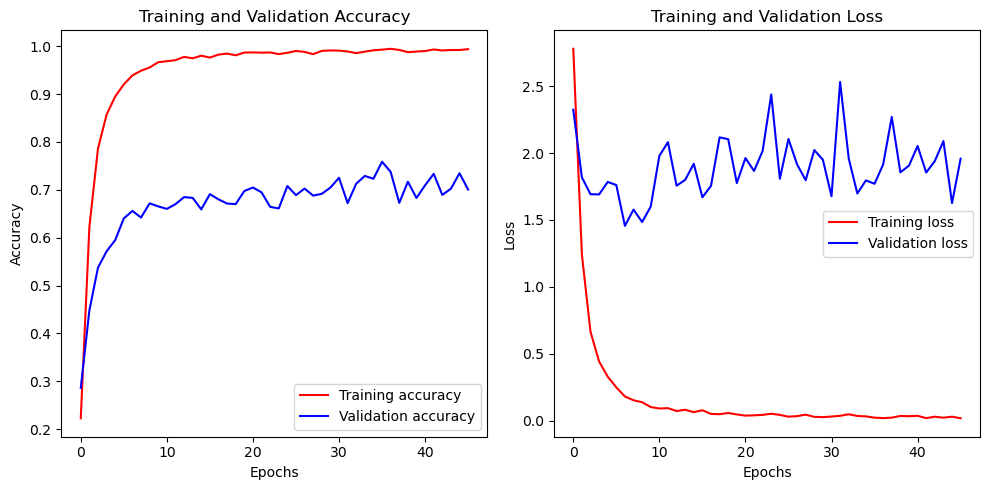

In [122]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(train_acc))

# Create a figure with two subplots
plt.figure(figsize=(10, 5))  # Adjust the size as needed

# Subplot 1: Training and validation accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')  # You can also use loc=0 for best location

# Subplot 2: Training and validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()

# Inception without Data Augmentation

In [6]:
inception_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

In [7]:
for layer in inception_model.layers[:249]:
    layer.trainable = False
for layer in inception_model.layers[249:]:
    layer.train = True

In [10]:
x = layers.GlobalAveragePooling2D()(inception_model.output) # global spatial average pooling layer
x = layers.Dense(1024, activation='relu')(x) # fully-connected layer                 
x = layers.Dense(29, activation='softmax')(x) # final layer with softmax activation       


In [11]:
model_2 = Model(inception_model.input, x) 
model_2.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [14]:
history_2 = model_2.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50
)

Epoch 1/50
100/100 [==============================] - 194s 2s/step - loss: 3.3861 - acc: 0.0470 - val_loss: 3.3406 - val_acc: 0.0556
Epoch 2/50
100/100 [==============================] - 214s 2s/step - loss: 3.1784 - acc: 0.1314 - val_loss: 3.1805 - val_acc: 0.1081
Epoch 3/50
100/100 [==============================] - 219s 2s/step - loss: 3.0047 - acc: 0.2488 - val_loss: 3.0668 - val_acc: 0.1694
Epoch 4/50
100/100 [==============================] - 222s 2s/step - loss: 2.8261 - acc: 0.3703 - val_loss: 2.9553 - val_acc: 0.2316
Epoch 5/50
100/100 [==============================] - 224s 2s/step - loss: 2.6479 - acc: 0.4700 - val_loss: 2.8558 - val_acc: 0.2709
Epoch 6/50
100/100 [==============================] - 225s 2s/step - loss: 2.4570 - acc: 0.5489 - val_loss: 2.7308 - val_acc: 0.3372
Epoch 7/50
100/100 [==============================] - 224s 2s/step - loss: 2.2864 - acc: 0.5989 - val_loss: 2.6293 - val_acc: 0.3775
Epoch 8/50
100/100 [==============================] - 236s 2s/step - 

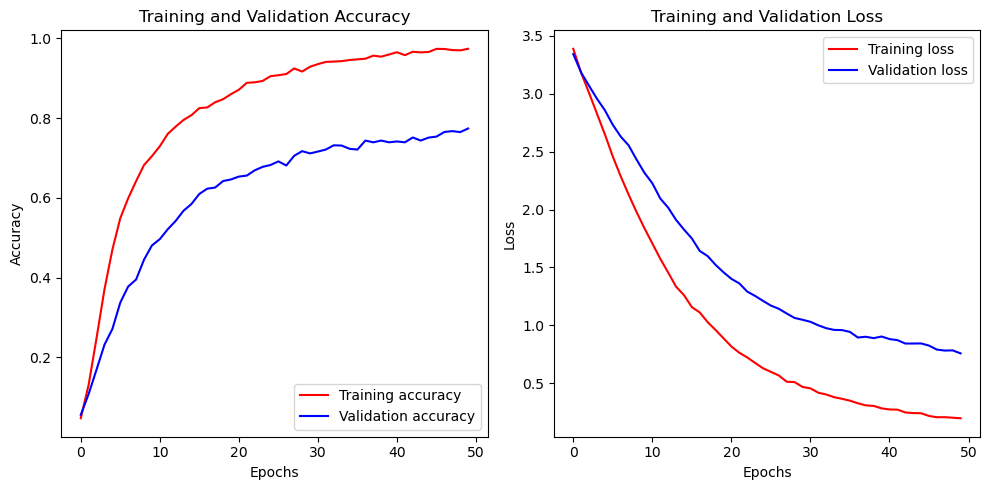

In [15]:
train_acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(train_acc))

# Create a figure with two subplots
plt.figure(figsize=(10, 5))  # Adjust the size as needed

# Subplot 1: Training and validation accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')  # You can also use loc=0 for best location

# Subplot 2: Training and validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()

In [21]:
from collections import defaultdict

predictions = model_2.predict(validation_generator, steps=len(validation_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

136/136 [==============================] - 151s 1s/step


In [28]:
# Find misclassified indices
misclassified_indices = np.where(predicted_classes != true_classes)[0]

idx_to_class = {v: k for k, v in validation_generator.class_indices.items()}

# Reset the generator before reusing
validation_generator.reset()

# Get paths and labels for misclassified images
misclassified_samples = [validation_generator.filepaths[index] for index in misclassified_indices]

# Convert numeric indices to class names for true and predicted labels
misclassified_true_labels = [idx_to_class[index] for index in true_classes[misclassified_indices]]
misclassified_pred_labels = [idx_to_class[index] for index in predicted_classes[misclassified_indices]]

misclassified_by_label = defaultdict(list)
for path, true, pred in zip(misclassified_samples, misclassified_true_labels, misclassified_pred_labels):
    if true in ['A', 'B', 'C']:  # Filter only classes of interest
        misclassified_by_label[true].append((path, pred))

# Select up to three examples per label where predictions were wrong
selected_examples = []
for label in ['A', 'B', 'C']:
    examples = misclassified_by_label[label][:4]
    for example in examples:
        selected_examples.append((label, example[0], example[1]))  

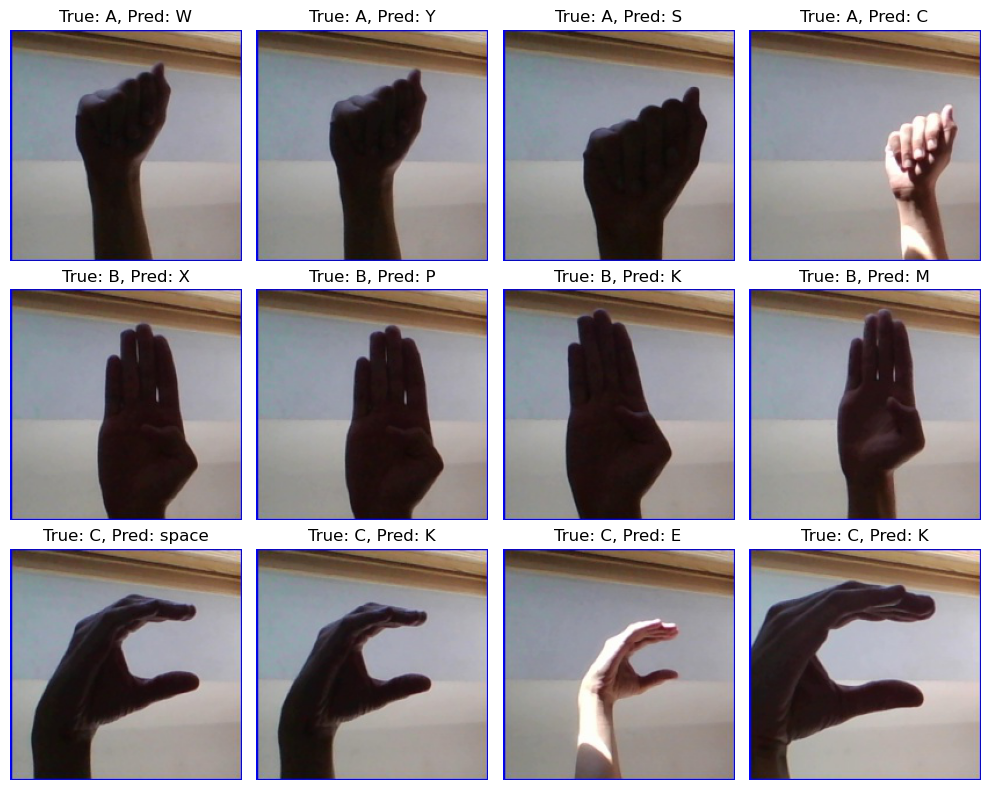

In [30]:
# Set up the figure with a large enough size
plt.figure(figsize=(10, 8))  # Adjust the size as needed

total_images = len(selected_examples)
num_columns = 4  # Display 9 images per row

for i, (true, path, pred) in enumerate(selected_examples):
    ax = plt.subplot(len(misclassified_by_label), num_columns, i + 1)  # Create a grid of len(labels) x 9
    img = plt.imread(path)
    plt.imshow(img)
    plt.title(f"True: {true}, Pred: {pred}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# InceptionV3 with Data Augumentation

In [5]:
datagen_augmented = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

traingen_augmented = datagen_augmented.flow_from_directory(TRAINING_PATH, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validgen_augmented = datagen_augmented.flow_from_directory(TRAINING_PATH, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")
     

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [12]:
TL_model = Model(inception_model.input, x) 
TL_model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [12]:
TL_history = TL_model.fit(
    traingen_augmented,
    validation_data=validgen_augmented,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
)

Epoch 1/50
100/100 [==============================] - 223s 2s/step - loss: 3.3734 - acc: 0.0548 - val_loss: 3.3359 - val_acc: 0.0528
Epoch 2/50
100/100 [==============================] - 238s 2s/step - loss: 3.1729 - acc: 0.1320 - val_loss: 3.1949 - val_acc: 0.1141
Epoch 3/50
100/100 [==============================] - 241s 2s/step - loss: 2.9815 - acc: 0.2527 - val_loss: 3.0926 - val_acc: 0.1803
Epoch 4/50
100/100 [==============================] - 244s 2s/step - loss: 2.7875 - acc: 0.3577 - val_loss: 2.9904 - val_acc: 0.2459
Epoch 5/50
100/100 [==============================] - 244s 2s/step - loss: 2.6073 - acc: 0.4516 - val_loss: 2.8796 - val_acc: 0.3103
Epoch 6/50
100/100 [==============================] - 238s 2s/step - loss: 2.4335 - acc: 0.5244 - val_loss: 2.7801 - val_acc: 0.3537
Epoch 7/50
100/100 [==============================] - 245s 2s/step - loss: 2.2739 - acc: 0.5745 - val_loss: 2.6744 - val_acc: 0.3950
Epoch 8/50
100/100 [==============================] - 270s 3s/step - 

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


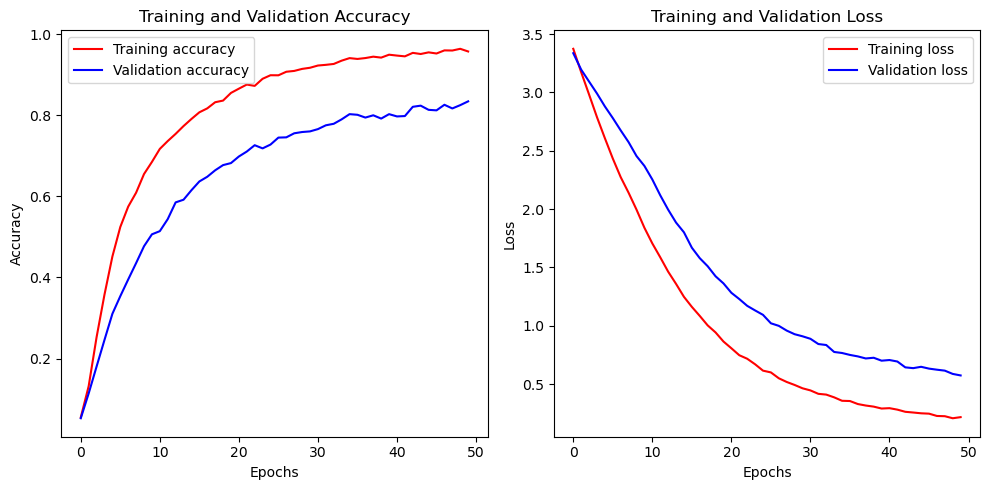

In [13]:
train_acc = TL_history.history['acc']
val_acc = TL_history.history['val_acc']
train_loss = TL_history.history['loss']
val_loss = TL_history.history['val_loss']

epochs = range(len(train_acc))

# Create a figure with two subplots
plt.figure(figsize=(10, 5))  # Adjust the size as needed

# Subplot 1: Training and validation accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')  # You can also use loc=0 for best location

# Subplot 2: Training and validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()

In [20]:
TL_model.save('best_models/asl_alphabet.h5'.format(9575))

# VGG16 without Data Augmentation

In [6]:
VGG16_model = VGG16(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)
for layer in VGG16_model.layers:
    layer.trainable = False
    
x = VGG16_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

In [7]:
VGG16_model = Model(VGG16_model.input, predictions) 
VGG16_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [9]:
VGG_history= VGG16_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=10,
)

Epoch 1/10
100/100 [==============================] - 982s 10s/step - loss: 2.8539 - accuracy: 0.2127 - val_loss: 1.5849 - val_accuracy: 0.5819
Epoch 2/10
100/100 [==============================] - 993s 10s/step - loss: 1.5501 - accuracy: 0.5047 - val_loss: 0.8395 - val_accuracy: 0.7622
Epoch 3/10
100/100 [==============================] - 993s 10s/step - loss: 1.0575 - accuracy: 0.6347 - val_loss: 0.5444 - val_accuracy: 0.8209
Epoch 4/10
100/100 [==============================] - 990s 10s/step - loss: 0.8489 - accuracy: 0.7175 - val_loss: 0.4815 - val_accuracy: 0.8628
Epoch 5/10
100/100 [==============================] - 986s 10s/step - loss: 0.7506 - accuracy: 0.7475 - val_loss: 0.4236 - val_accuracy: 0.8481
Epoch 6/10
100/100 [==============================] - 983s 10s/step - loss: 0.6551 - accuracy: 0.7805 - val_loss: 0.4188 - val_accuracy: 0.8644
Epoch 7/10
100/100 [==============================] - 981s 10s/step - loss: 0.5719 - accuracy: 0.8034 - val_loss: 0.3333 - val_accuracy:

In [10]:
VGG_history= VGG16_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=20,
    initial_epoch=10
)

Epoch 11/20
100/100 [==============================] - 951s 10s/step - loss: 0.4140 - accuracy: 0.8559 - val_loss: 0.3363 - val_accuracy: 0.8709
Epoch 12/20
100/100 [==============================] - 981s 10s/step - loss: 0.4346 - accuracy: 0.8517 - val_loss: 0.3016 - val_accuracy: 0.8919
Epoch 13/20
100/100 [==============================] - 980s 10s/step - loss: 0.3941 - accuracy: 0.8695 - val_loss: 0.2875 - val_accuracy: 0.8953
Epoch 14/20
100/100 [==============================] - 983s 10s/step - loss: 0.3603 - accuracy: 0.8748 - val_loss: 0.3103 - val_accuracy: 0.8959
Epoch 15/20
100/100 [==============================] - 986s 10s/step - loss: 0.3917 - accuracy: 0.8714 - val_loss: 0.2832 - val_accuracy: 0.8906
Epoch 16/20
100/100 [==============================] - 993s 10s/step - loss: 0.3874 - accuracy: 0.8703 - val_loss: 0.2269 - val_accuracy: 0.9275
Epoch 17/20
100/100 [==============================] - 976s 10s/step - loss: 0.3682 - accuracy: 0.8791 - val_loss: 0.2744 - val_ac

In [31]:
VGG16_model.save('vgg_1_asl_alphabet.h5'.format(9575))

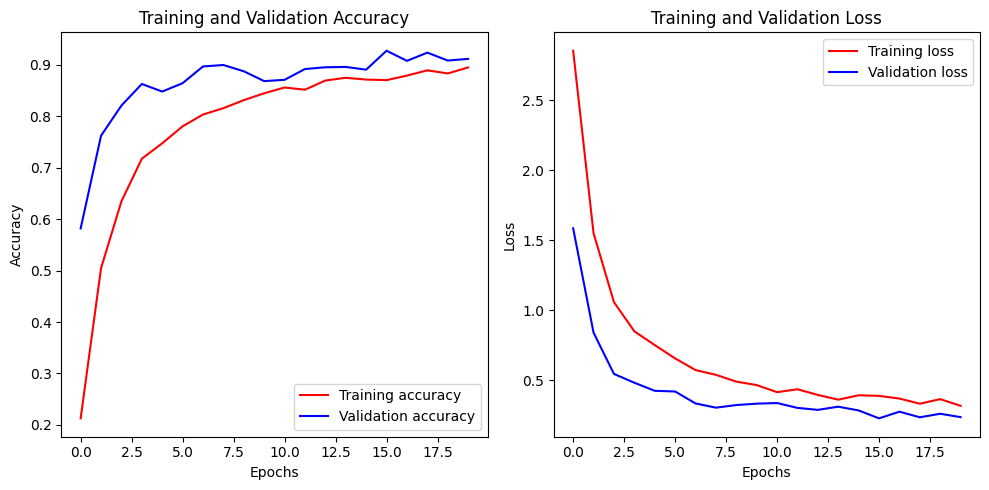

In [27]:
epochs = range(len(train_acc))

# Create a figure with two subplots
plt.figure(figsize=(10, 5))  # Adjust the size as needed

# Subplot 1: Training and validation accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')  # You can also use loc=0 for best location

# Subplot 2: Training and validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()

In [32]:
from keras.models import load_model
model = load_model('vgg_1_asl_alphabet.h5')

In [34]:
classes = os.listdir(TRAINING_PATH)
classes.sort()
test_images = os.listdir(TEST_PATH)
total_test_cases = len(test_images)
total_correctly_classified = 0
total_misclassified = 0
for i, test_image in enumerate(test_images):
    image_location = TEST_PATH + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (200, 200))
    img = np.array(img) / 255.
    img = img.reshape((1, 200, 200, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} - Predicted class: {}'.format(
        actual, predicted), end=' ')
    if actual == predicted:
      print('PASS!')
      total_correctly_classified += 1
    else:
      print('FAIL!')
      total_misclassified += 1
print("=" * 20)
test_accuracy = (total_correctly_classified / total_test_cases) * 100
test_error_rate = (total_misclassified / total_test_cases) * 100

print('Test accuracy (%):', test_accuracy)
print('Test error rate (%):', test_error_rate)
print('Number of misclassified classes:', total_misclassified)
print('Number of correctly classified classes', total_correctly_classified)

1/1 [==============================] - 0s 100ms/step
Actual class: F - Predicted class: F PASS!
1/1 [==============================] - 0s 104ms/step
Actual class: G - Predicted class: G PASS!
1/1 [==============================] - 0s 92ms/step
Actual class: L - Predicted class: L PASS!
1/1 [==============================] - 0s 95ms/step
Actual class: M - Predicted class: M PASS!
1/1 [==============================] - 0s 108ms/step
Actual class: R - Predicted class: R PASS!
1/1 [==============================] - 0s 110ms/step
Actual class: S - Predicted class: S PASS!
1/1 [==============================] - 0s 102ms/step
Actual class: X - Predicted class: X PASS!
1/1 [==============================] - 0s 104ms/step
Actual class: Y - Predicted class: Y PASS!
1/1 [==============================] - 0s 104ms/step
Actual class: U - Predicted class: U PASS!
1/1 [==============================] - 0s 97ms/step
Actual class: T - Predicted class: T PASS!
1/1 [==============================] - 0s 9